# Absolute seismic inversion in time domain - Volve data

This notebook is a continuation of the **SeismicInversion-Volve** notebook and aims at performing absolute seismic inversion.

Once again we will use Volve data as input data to our inversion and we will leverage the open-source segyio and pylops libraries to accomplish our task as follows:

- Data and velocity model are read from SEG-Y file using segyio (note that for the Volve data we will have to deal with irregular geometry)
- Velocity model is resampled to the data grid (both time and spatial sampling) and scaled to become the background AI for inversion.
- Absolute inversion is applied by means of ``pylops.avo.poststack.PoststackInversion``
- Inverted data is saved back to SEG-Y file using segyio

We cannot provide the data given its size, but the Volve data is hosted on a Azure Blob storage so it is very easy to download it using the Azure CLI (https://github.com/Azure/azure-cli or ``pip install azure-cli`` would do).

First of all let's investigate what is present in the `Seismic` directory

In [1]:
#!az storage blob list --account-name dataplatformblvolve --container-name pub --prefix Seismic/ --sas-token "$YOURTOKEN" > ../data/seismicinversion/list_seismic.txt

In [2]:
!head -n 60 ../data/seismicinversion/list_seismic.txt

[
  {
    "content": null,
    "deleted": false,
    "metadata": null,
    "name": "Seismic/README.txt",
    "properties": {
      "appendBlobCommittedBlockCount": null,
      "blobTier": "Cool",
      "blobTierChangeTime": null,
      "blobTierInferred": true,
      "blobType": "BlockBlob",
      "contentLength": 1011,
      "contentRange": null,
      "contentSettings": {
        "cacheControl": null,
        "contentDisposition": null,
        "contentEncoding": null,
        "contentLanguage": null,
        "contentMd5": "VNB2po0tluppJS2dg4Y8WQ==",
        "contentType": "text/plain"
      },
      "copy": {
        "completionTime": null,
        "id": null,
        "progress": null,
        "source": null,
        "status": null,
        "statusDescription": null
      },
      "creationTime": "2018-05-14T09:37:35+00:00",
      "deletedTime": null,
      "etag": "0x8D5B97E533330A7",
      "lastModified": "2018-05-14T09:37:35+00:00",
      "lease": {
        "duration": null,
    

where you will need to substitute ``$YOURTOKEN`` with your personal token. To get a token, simply register at https://data.equinor.com/authenticate and find the token in the red text in the Usage section. Ensure to copy everything from `?sv=` to `=rl` in place of ``$YOURTOKEN``.

We can now download the file of interest

In [3]:
# TO BE RUN ONLY ONCE TO RETRIEVE THE DATA
#!az storage blob download --account-name dataplatformblvolve --container-name pub --name Seismic/ST10010/Stacks/ST10010ZC11_PZ_PSDM_KIRCH_FULL_T.MIG_FIN.POST_STACK.3D.JS-017536.segy --file ST10010ZC11_PZ_PSDM_KIRCH_FULL_T.MIG_FIN.POST_STACK.3D.JS-017536.segy --sas-token "$YOURTOKEN"
#!mv ST10010ZC11_PZ_PSDM_KIRCH_FULL_T.MIG_FIN.POST_STACK.3D.JS-017536.segy ../data/seismicinversion

In [4]:
# TO BE RUN ONLY ONCE TO RETRIEVE THE DATA
#!az storage blob download --account-name dataplatformblvolve --container-name pub --name Seismic/ST10010/Stacks/ST10010ZC11_STACK_VEL_RMS_T.MIG_VEL.VELOCITY.3D.JS-017527.segy --file ST10010ZC11_STACK_VEL_RMS_T.MIG_VEL.VELOCITY.3D.JS-017527.segy --sas-token "$YOURTOKEN"
#!mv ST10010ZC11_STACK_VEL_RMS_T.MIG_VEL.VELOCITY.3D.JS-017527.segy ../data/seismicinversion

Let's first import all the libraries we need

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import numpy as np
import segyio
import pylops
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.interpolate import RegularGridInterpolator

And define some of the input parameters we will use later (refer to the following for a more detailed description of the types of inversion)

In [6]:
# Data
itmin = 450 # index of first time/depth sample in data used in colored inversion
itmax = 750 # number of samples of statistical wavelet

# Subsampling (can save file at the end only without subsampling)
jt = 1
jil = 1
jxl = 1

# Wavelet estimation
nt_wav = 21 # number of samples of statistical wavelet
nfft = 512 # number of samples of FFT
wav_scaling = 1e1 # wavelet scaling full
#wav_scaling = 2e1 # wavelet scaling near

# Trace-by-Trace Inversion
epsI_tt = 1e-3 # damping

# Spatially simultaneous
niter_sr = 3 # number of iterations of lsqr
epsI_sr = 1e-4 # damping
epsR_sr = 1e2 # spatial regularization

# Blocky simultaneous
niter_out_b = 3 # number of outer loop iterations
niter_in_b = 1 # number of inner loop iterations
niter_b = 10 # number of iterations of lsqr
mu_b = 1e-1 # damping for data term
epsI_b = 1e-4 # damping
epsR_b = 0.1 # spatial regularization
epsRL1_b = 1. # blocky regularization

Let's now read the Volve data.

Note that we add the `ignore_geometry=True` parameter when we open the file. As we will see the geometry in this file is not regular, so we cannot rely on the inner working of segyio to get our data into a 3d numpy.

We thus need to read all ILs, XLs and traces and reorganize them ourselves into a regular grid. No worries, numpy will do most of the hard work.

(1961.0, 2680.0, 3000.0, 1804.0)

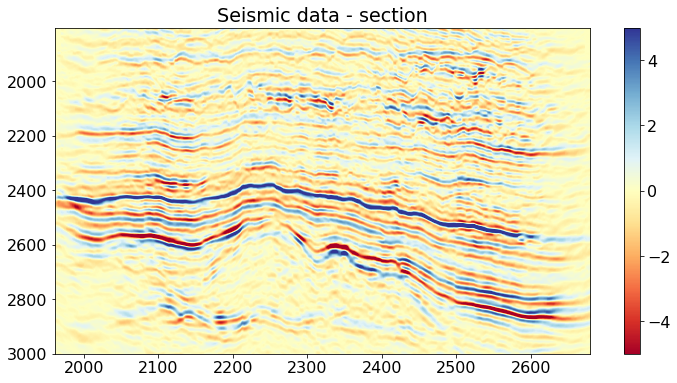

In [7]:
# Full
segyfile = '../data/seismicinversion/ST10010ZC11_PZ_PSDM_KIRCH_FULL_T.MIG_FIN.POST_STACK.3D.JS-017536.segy'
segyfile_inverted = '../data/seismicinversion/ST10010ZC11_PZ_PSDM_KIRCH_FULL_T.MIG_FIN.POST_STACK.3D.JS-017536_inverted.segy'
# Near
#segyfile = '../data/seismicinversion/ST10010ZC11_PZ_PSDM_KIRCH_NEAR_T.MIG_FIN.POST_STACK.3D.JS-017536.segy'
#segyfile_inverted = '../data/seismicinversion/ST10010ZC11_PZ_PSDM_KIRCH_NEAR_T.MIG_FIN.POST_STACK.3D.JS-017536_inverted.segy'
f = segyio.open(segyfile, ignore_geometry=True)

traces = segyio.collect(f.trace)[:]
traces = traces[:, itmin:itmax]
ntraces, nt = traces.shape

t = f.samples[itmin:itmax]
il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

# Define regular IL and XL axes
il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# Look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))

# Reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces

# Subsample
d = d[::jil, ::jxl, ::jt]
ilines = ilines[::jil]
xlines = xlines[::jxl]
t = t[::jt]
nil, nxl, nt = len(ilines), len(xlines), len(t)

# Display data
plt.figure(figsize=(12, 6))
plt.imshow(d[nil//2].T, cmap='RdYlBu', vmin=-5, vmax=5,
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Seismic data - section')
plt.colorbar()
plt.axis('tight')

We read also the rms velocity model and convert it to interval velocity. 

In this case, the SEG-Y file is in a regular grid, but the grid is different from that of the data.
Let's also resample the velocity model to the grid of the data.

In [8]:
def vint2vrms(vint, t):
    nt = t.size
    dt = np.diff(t)
    vrms = np.zeros(nt)
    vrms[:-1] = np.cumsum(dt * (vint[:-1]**2));
    vrms[:-1] = np.sqrt(vrms[:-1] / t[:-1]-t[0])
    vrms[-1] = vrms[-2]
    return vrms

def vrms2vint(vrms, t):
    nt = t.size
    i1 = np.arange(0, nt-1)
    i2 = np.arange(1, nt)
    vint = np.zeros(nt)
    vrms2 = vrms ** 2
    vint[i1]= np.sqrt((vrms2[i2]*(t[i2] - t[0]) - vrms2[i1]*(t[i1] - t[0])) / (t[i2] - t[i1]))
    
    #find and process non-physical ones
    inp = np.where(vint<0);
    if len(inp):
        vint[inp] = np.nan
    return vint

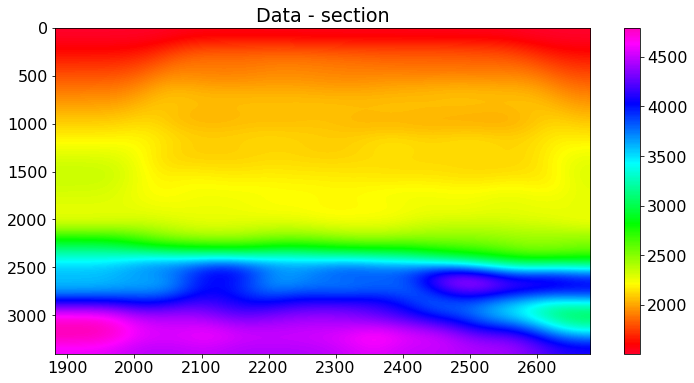

In [9]:
segyfilev = '../data/seismicinversion/ST10010ZC11_STACK_VEL_RMS_T.MIG_VEL.VELOCITY.3D.JS-017527.segy'
fv = segyio.open(segyfilev)
vrms = segyio.cube(fv)
trms = fv.samples

v = np.zeros_like(vrms)
for iil in range(vrms.shape[0]):
    for ixl in range(vrms.shape[1]):
        v[iil, ixl] = vrms2vint(vrms[iil, ixl], trms / 1000.)
v = gaussian_filter(v, sigma=30)

plt.figure(figsize=(12, 6))
plt.imshow(v[v.shape[0]//2].T, cmap='gist_rainbow',
           extent=(fv.xlines[0], fv.xlines[-1], trms[-1], trms[0]))
plt.title('Data - section')
plt.colorbar()
plt.axis('tight');

IL, XL, T = np.meshgrid(ilines, xlines, t, indexing='ij')
vinterp = RegularGridInterpolator((fv.ilines, fv.xlines, fv.samples), v, 
                                  bounds_error=False, fill_value=0)
vinterp = vinterp(np.vstack((IL.ravel(), XL.ravel(), T.ravel())).T)
vinterp = vinterp.reshape(nil, nxl, nt)

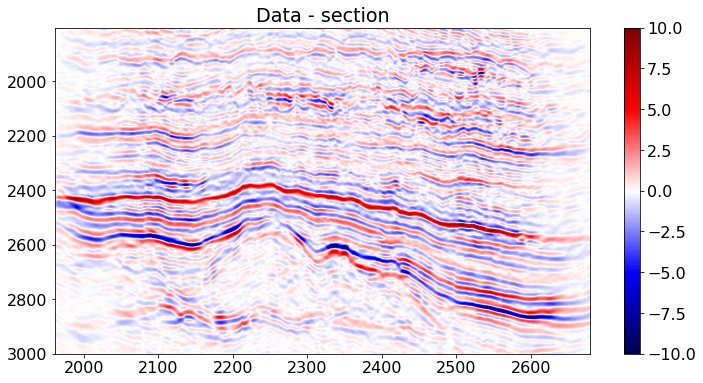

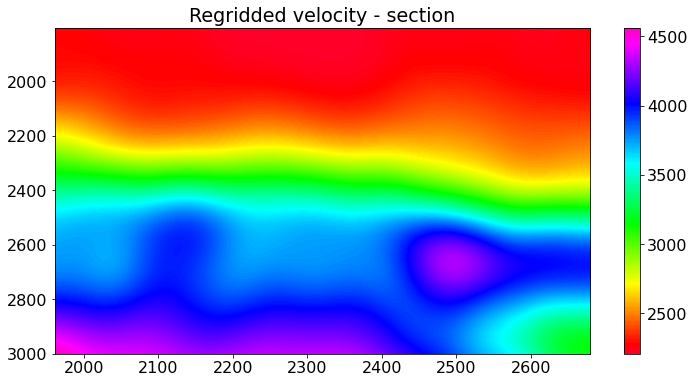

In [10]:
# Display data
plt.figure(figsize=(12, 6))
plt.imshow(d[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Data - section')
plt.colorbar()
plt.axis('tight');

plt.figure(figsize=(12, 6))
plt.imshow(vinterp[nil//2].T, cmap='gist_rainbow',
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Regridded velocity - section')
plt.colorbar()
plt.axis('tight');

We need now to scale this model to its acoustic impedance equivalent. 

This calibration step was performed outside of this notebook using a welllog and this velocity model along a well trajectory. In this example we will simply use a scaling (gradient) and a shift (intercept) from that study.

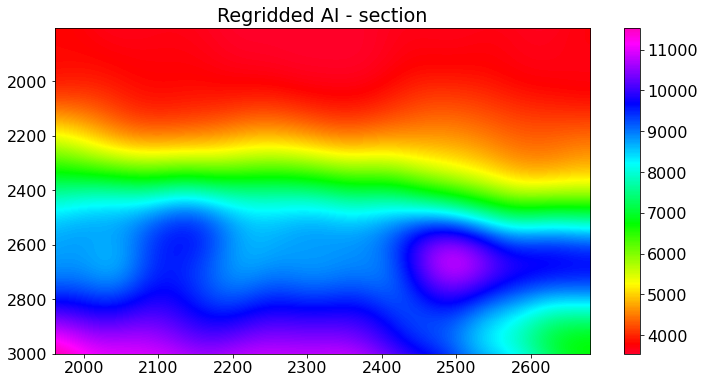

In [11]:
intercept = -3952.2622879733026 #-3218.0003362662665
gradient = 3.3952561093488325 #3.2468122679241023

aiinterp = intercept + gradient*vinterp

# Display data
plt.figure(figsize=(12, 6))
plt.imshow(aiinterp[nil//2].T, cmap='gist_rainbow',
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Regridded AI - section')
plt.colorbar()
plt.axis('tight');

Let's now try to get a quick estimate of the wavelet in our data using a simple statistical wavelet estimation in frequency domain.

Note that this notebook is not focused on the pre-processing but we will need access to this to apply a colored inversion.

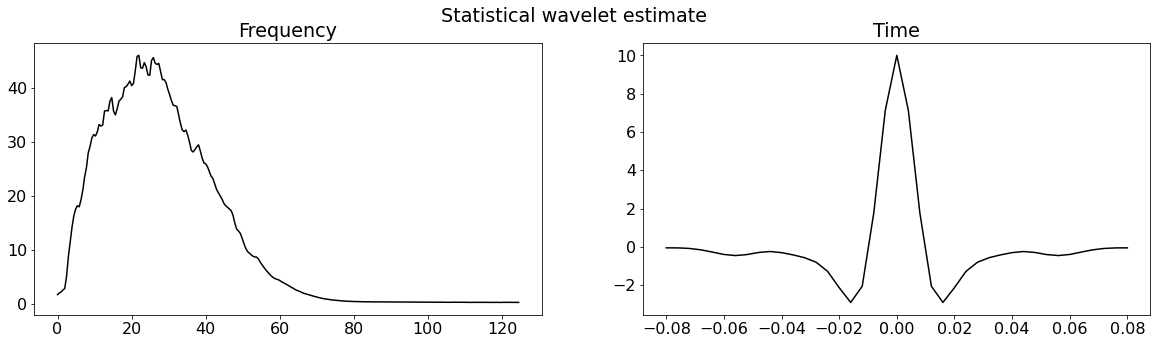

In [12]:
# Wavelet time axis
t_wav = np.arange(nt_wav) * (dt/1000)
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# Estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(d[::2, ::2], nfft, axis=-1)), axis=(0, 1))
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# Create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()
wav_est *= wav_scaling

# Display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Time');

We can apply seismic inversion using a starting background AI model. The inverted AI model will therefore have the correct physical quantities of acoustic impedance.

In [13]:
# Swap time axis back to first dimension
d = np.swapaxes(d, -1, 0)
aiinterp = np.swapaxes(aiinterp, -1, 0)

m0 = np.log(aiinterp)
m0[np.isnan(m0)] = 0

# Inversion
m_abs, r_abs = \
    pylops.avo.poststack.PoststackInversion(d, wav_est, m0=m0, explicit=False, 
                                            epsR=epsR_b, epsRL1=epsRL1_b,
                                            **dict(mu=mu_b, niter_outer=niter_out_b, 
                                                   niter_inner=niter_in_b, show=True,
                                                   iter_lim=niter_b, damp=epsI_b))

# Swap time axis back to last dimension
aiinterp = np.swapaxes(aiinterp, 0, -1)
d = np.swapaxes(d, 0, -1)
m_abs = np.swapaxes(np.exp(m_abs), 0, -1)
r_abs = np.swapaxes(r_abs, 0, -1)

SplitBregman
-----------------------------------------------------------------
The Operator Op has 86616000 rows and 86616000 cols
niter_outer =   3     niter_inner =   1   tol = 1.00e-10
mu = 1.00e-01         epsL1 = [1.0]	  epsL2 = [0.1]
-----------------------------------------------------------------
    Itn       x[0]           r2norm           r12norm
     1     8.1857e+00       1.066e+05        3.471e+06
     2     8.1844e+00       8.961e+04        3.275e+06
     3     8.1840e+00       1.150e+05        3.128e+06

Iterations = 3        Total time (s) = 2412.95
-----------------------------------------------------------------



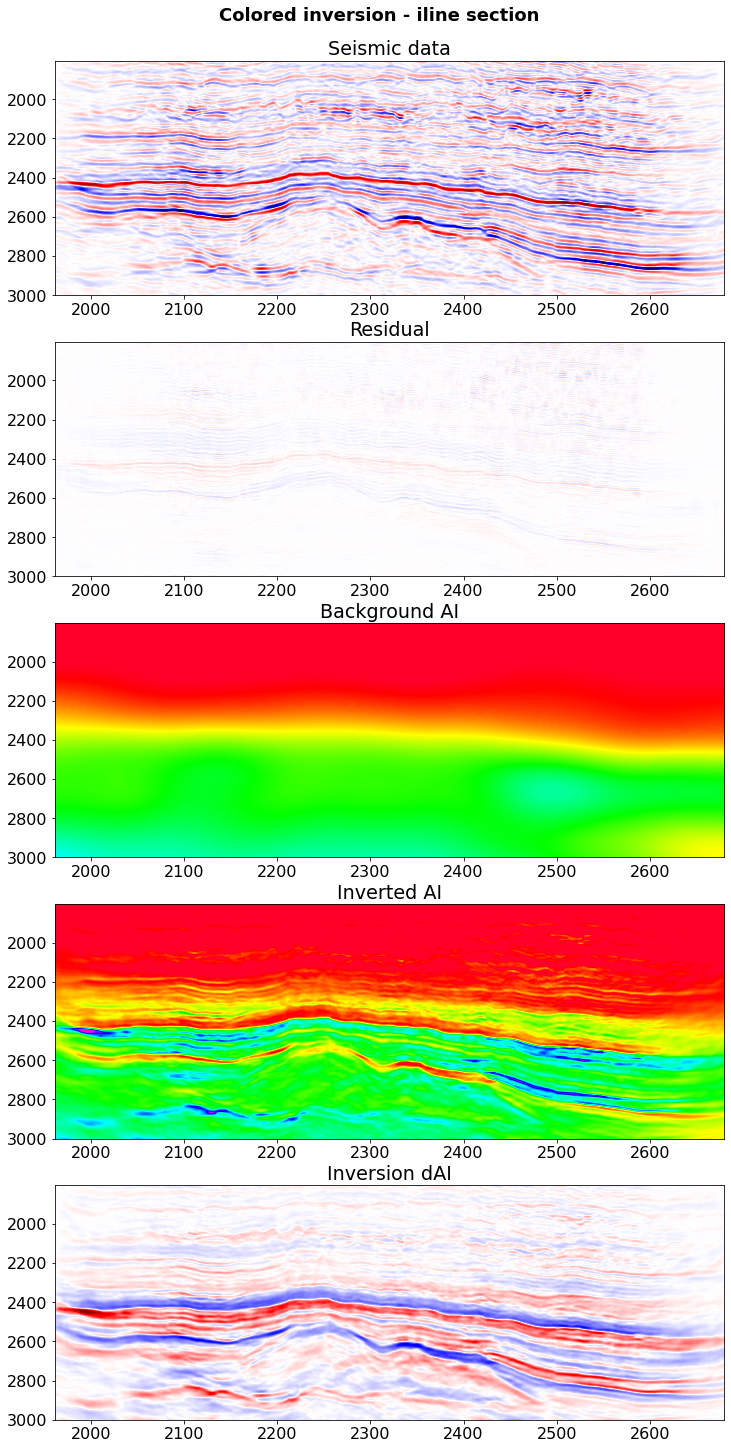

In [14]:
# Visualize
fig, axs = plt.subplots(5, 1, figsize=(12, 25))
fig.suptitle('Colored inversion - iline section',
             y=0.91, fontweight='bold', fontsize=18)
axs[0].imshow(d[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(r_abs[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[1].set_title('Residual')
axs[1].axis('tight')
axs[2].imshow(aiinterp[nil//2].T, cmap='gist_rainbow',
              vmin=4000, vmax=17000,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[2].set_title('Background AI')
axs[2].axis('tight')
axs[3].imshow(m_abs[nil//2].T, cmap='gist_rainbow',
              vmin=4000, vmax=17000,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[3].set_title('Inverted AI')
axs[3].axis('tight');
axs[4].imshow(m_abs[nil//2].T -  aiinterp[nil//2].T, cmap='seismic',
          vmin=-0.7*(m_abs- aiinterp).max(), vmax=0.7*(m_abs- aiinterp).max(),
          extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[4].set_title('Inversion dAI')
axs[4].axis('tight');

Let's finally visualize a single trace

Finally we write the cube back to a segy. As the geometry of the input data was irregular, we need to first bring the traces of the inverted cube back to their original order

In [15]:
traces_to_save =  m_abs[ilgrid.ravel()[traces_available.ravel()],
                        xlgrid.ravel()[traces_available.ravel()]]

We can now use segyio once again to create a new SEG-Y with different time axis (or zoomed area) and populate it with both headers and data

In [16]:
with segyio.open(segyfile, ignore_geometry=True) as src:
        spec = segyio.spec()
        spec.format = int(src.format)
        spec.samples = t
        spec.tracecount = src.tracecount

        with segyio.create(segyfile_inverted, spec) as dst:
            # Copy all textual headers, including possible extended
            for i in range(src.ext_headers):
                dst.text[i] = src.text[i]

            # Copy the binary header, then insert the modifications needed for the new time axis
            dst.bin = src.bin
            dst.bin = {segyio.BinField.Samples: itmax-itmin}
            
            # Copy all trace headers to destination file
            dst.header = src.header 

            # Copy data and modify trace header
            for itrace in range(dst.tracecount):
                dst.header[itrace] = {segyio.TraceField.TRACE_SAMPLE_COUNT: itmax-itmin,
                                      segyio.TraceField.DelayRecordingTime: int(t[0])} 
                dst.trace[itrace] = traces_to_save[itrace].astype('float32')
                

Again, let's read the file back and check that what we saved is correct


In [17]:
f1 = segyio.open(segyfile_inverted, ignore_geometry=True)
traces1 = segyio.collect(f1.trace)[:]

In [18]:
np.allclose(traces1, traces_to_save)

True